In [1059]:
# A bit of setup
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Functions

In [1060]:
# X: d x n np.ndarray
# return a d x n ndarray
def softmax(X):
    X -= X.max(axis=0)  # for each column, substract the max over row
    eX = np.exp(X) 
    return eX / eX.sum(axis=0)  # softmax for each column

In [1061]:
# return a 1xn predicted class label with highest softmax probabilities
# X1: (d+1) x n, features of all samples 
# W1: c x (d+1), weights
def predict_softmax(X1, W1):
    Y_soft = softmax( W1.dot(X1) )  # c x n
    y_hat = np.argmax( Y_soft, axis=0 )  # 1 x n
    return y_hat

In [1062]:
# return a LogLoss value between true label y and softmax probabilities
# X: d x n, d features of n samples 
# y: 1 x n, class label in [0, c), dtype='uint8'
# W: c x d, weights
def loss_softmax(X, y, W):
    Y_soft = softmax( W.dot(X) )  # c x n
    y_prob = Y_soft[y, range(len(y))]  # 1 x n
    #print "len(y)=", len(y)
    return -np.log(y_prob).mean()

In [1063]:
# Use partial derivative df = (f(X+h) - f(X-h)) / 2h on each feature of X
# func: a function that takes a single argument
# X is the point (numpy array) to evaluate the gradient at
# h: step
def gradient(func, X, h=0.00001):
    grad = np.zeros(X.shape)
    # iterate over all indexes in X
    it = np.nditer(X, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        # evaluate function at x+h
        ix = it.multi_index
        old_value = X[ix]
        X[ix] = old_value + h 
        fxh1 = func(X) # evalute f(x + h)
        #print X, fxh1
        X[ix] = old_value - h 
        fxh2 = func(X) # evalute f(x - h)
        #print X, fxh2
        X[ix] = old_value # restore to previous value (very important!)

        # compute the partial derivative
        grad[ix] = (fxh1 - fxh2) / (2*h) # the slope
        it.iternext() # step to next dimension
    return grad

In [1064]:
# W: a ndarray of weights
# return the regularization penalty
def regularization(W, reg='l2'):
    if reg != 'l2':
        raise
    else:
        return 0.5 * np.sum(W*W)          

In [1065]:
# W: a ndarray of weights
# return the gradient of regularization loss, 0.5|W|_2
#  grad is an array of the same size
def gradient_regularization(W, reg='l2'):
    if reg != 'l2':
        raise
    else:
        return W        

### Gradient Check

In [1066]:
## test 1
f = lambda x: -3*x*x + 2*x + 4
X = np.array(3.0)
gradient( f, X )

array(-16.000000000282455)

In [1067]:
# test 2
f = lambda X: X[0]*X[1]
X = np.array([3.0, 4.0])
gradient( f, X )

array([ 4.,  3.])

# Sample Data

(-1, 1)

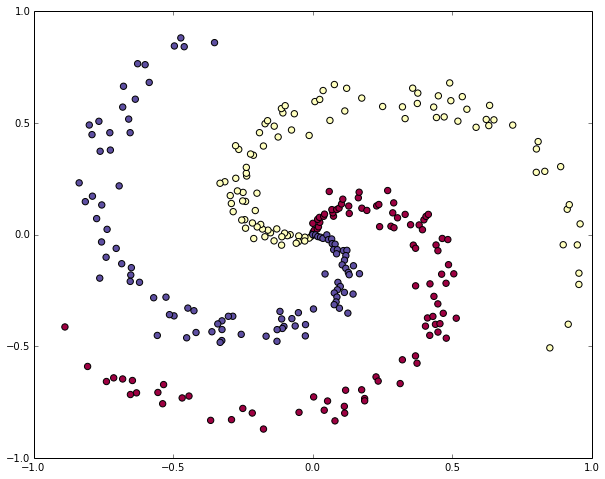

In [1068]:
np.random.seed(0)
n = 100 # number of points per class
d = 2 # dimensionality
c = 3 # number of classes
X = np.zeros((d, n*c))
y = np.zeros(n*c, dtype='uint8')
for j in xrange(c):
    cols = range(n*j, n*(j+1))
    r = np.linspace(0.0, 1, n) # radius
    t = np.linspace(j*4, (j+1)*4, n) + np.random.randn(n)*0.2 # theta
    X[:, cols] = np.vstack( (r*np.sin(t), r*np.cos(t)) )
    y[cols] = j
fig = plt.figure()
plt.scatter(X[0, :], X[1, :], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim([-1,1])
plt.ylim([-1,1])
#fig.savefig('spiral_raw.png')

# Initialization

In [1069]:
np.random.seed(0)
vec1 = np.ones(n*c)
X1 = np.vstack((X, vec1)) # extended features including intercept

### Weights to learn

In [1070]:
np.random.seed(1122)
W1 = 0.01 * np.random.randn(c, d+1)   # true weights, including intercept

In [1071]:
loss_softmax(X1, y, W1)

1.0997415359631191

In [1072]:
regularization( W1[:,:-1] ) # intercept is not considered

0.00024792444292692713

# Training

### Loss function on weights

In [1073]:
## given training data (X1 and y), loss is func of W1 only
def loss_on_weights( W1 ):
    return loss_softmax(X1, y, W1)

### Gradient Decendent

In [1074]:
## Note: this code is generic of loss functions
iter = 0
step = 1e-1
reg_strength = 1e-3
for iter in xrange(5001):
    loss = loss_on_weights( W1 ) + reg_strength * regularization( W1 ) 
    grad_W1 = gradient( loss_on_weights, W1 )
    grad_reg = np.hstack( (gradient_regularization( W1[:,:-1] ), np.zeros((c,1))) ) # not regularize intercept
    #grad_reg = gradient_regularization( W1 )
    grad_W1 += reg_strength * grad_reg
    W1 += - step * grad_W1
    if iter % 100 == 0:
        print "iter %d: loss = %f" % ( iter, loss )

iter 0: loss = 1.099742
iter 100: loss = 0.920711
iter 200: loss = 0.853786
iter 300: loss = 0.823779
iter 400: loss = 0.808513
iter 500: loss = 0.800059
iter 600: loss = 0.795092
iter 700: loss = 0.792046
iter 800: loss = 0.790117
iter 900: loss = 0.788865
iter 1000: loss = 0.788036
iter 1100: loss = 0.787480
iter 1200: loss = 0.787101
iter 1300: loss = 0.786841
iter 1400: loss = 0.786661
iter 1500: loss = 0.786536
iter 1600: loss = 0.786448
iter 1700: loss = 0.786386
iter 1800: loss = 0.786342
iter 1900: loss = 0.786311
iter 2000: loss = 0.786289
iter 2100: loss = 0.786273
iter 2200: loss = 0.786262
iter 2300: loss = 0.786254
iter 2400: loss = 0.786248
iter 2500: loss = 0.786244
iter 2600: loss = 0.786241
iter 2700: loss = 0.786239
iter 2800: loss = 0.786237
iter 2900: loss = 0.786236
iter 3000: loss = 0.786235
iter 3100: loss = 0.786235
iter 3200: loss = 0.786234
iter 3300: loss = 0.786234
iter 3400: loss = 0.786234
iter 3500: loss = 0.786234
iter 3600: loss = 0.786233
iter 3700: lo

### Evaluation

In [1075]:
loss_softmax(X1, y, W1)

0.77599310455207482

In [1076]:
regularization( W1[:,:-1] )

10.236540303348971

In [1077]:
W1

array([[ 1.03170231, -2.37412216, -0.0195062 ],
       [ 1.11430157,  2.7727644 , -0.05282607],
       [-2.16291905, -0.40509957,  0.06222512]])

In [1078]:
y_pred = predict_softmax(X1, W1)

In [1079]:
y_pred

array([2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1,
       1])

In [1080]:
print 'training accuracy: %.2f' % (np.mean(y_pred == y))


training accuracy: 0.49


### Plot Classification Boundary

In [1081]:
# plot the resulting classifier
h = 0.02
x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
# xx, yy are two matrix

In [1082]:
vv1 = np.ones( xx.shape[0] * xx.shape[1] ) # vector of 1's
vv1.shape

(36284,)

In [1083]:
XX = np.c_[xx.ravel(), yy.ravel()].T
XX.shape

(2, 36284)

In [1084]:
XX1 = np.vstack( (XX, vv1) )

(-1.8712034092398278, 1.8687965907601756)

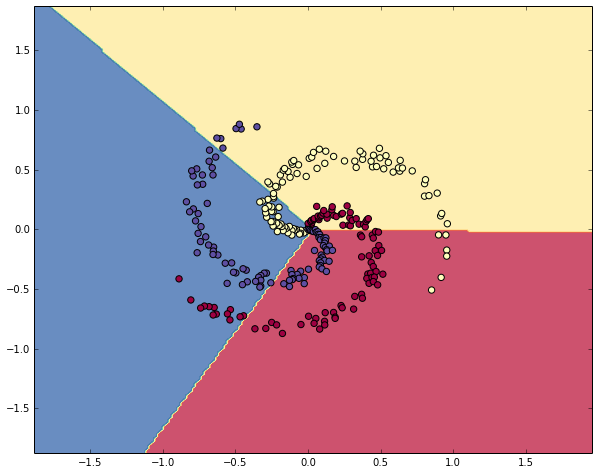

In [1085]:
Z = W1.dot( XX1 )
Z = np.argmax(Z, axis=0)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[0, :], X[1, :], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#fig.savefig('spiral_linear.png')